# Auxiliary Task: Predict NPC Animation ID from Vision

**Goal**: Test if a CNN can recognize NPC attack animations from stacked frames alone (no state).

**Why**: If the model can learn to visually recognize animations, this representation could help with dodge timing prediction. Currently the model gets `NpcAnimId` directly from state - it doesn't need to "see" attacks.

**Setup**:
- Input: Stack of N frames (e.g., 9 frames = current + 8 history)
- Output: NPC animation ID (classification)
- No state features - pure vision

In [1]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Config
DATASET_PATH = Path('../../dataset/margit_100_256x144_v2.zarr')
NUM_HISTORY_FRAMES = 8  # Total 9 frames including current
NPC_ANIM_IDX = 18  # Index in state array
BATCH_SIZE = 32
NUM_EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Load dataset
zarr_root = zarr.open(str(DATASET_PATH), mode='r')
episodes = sorted([k for k in zarr_root.keys() if k.startswith('episode_')])
print(f"Loaded {len(episodes)} episodes")

# Get all unique animation IDs and their counts
all_anim_ids = []
for ep_name in tqdm(episodes, desc="Scanning animations"):
    ep = zarr_root[ep_name]
    state = ep['state'][:]
    anims = state[:, NPC_ANIM_IDX].astype(int)
    all_anim_ids.extend(anims.tolist())

anim_counts = Counter(all_anim_ids)
print(f"\nUnique animations: {len(anim_counts)}")
print(f"\nTop 20 animations by frequency:")
for anim, count in anim_counts.most_common(20):
    print(f"  {anim}: {count} ({count/len(all_anim_ids)*100:.1f}%)")

Loaded 100 episodes


Scanning animations: 100%|██████████| 100/100 [00:00<00:00, 379.62it/s]


Unique animations: 53

Top 20 animations by frequency:
  2002000: 12462 (13.1%)
  2003022: 6273 (6.6%)
  2003017: 6015 (6.3%)
  2003029: 5563 (5.9%)
  2009000: 5093 (5.4%)
  2003026: 4959 (5.2%)
  2003021: 4881 (5.1%)
  2003027: 4570 (4.8%)
  2002003: 3945 (4.2%)
  2002002: 3809 (4.0%)
  41002: 3283 (3.5%)
  41001: 3066 (3.2%)
  2003025: 2790 (2.9%)
  41000: 2467 (2.6%)
  2003006: 2213 (2.3%)
  2003008: 2118 (2.2%)
  2003033: 1998 (2.1%)
  2003000: 1749 (1.8%)
  2003011: 1707 (1.8%)
  2003024: 1486 (1.6%)


In [3]:
# Filter to top N animations (treat rest as "other")
TOP_N_ANIMS = 15  # Classify top 15 animations, rest are "other"
MIN_SAMPLES = 500  # Minimum samples per class

top_anims = [anim for anim, count in anim_counts.most_common(TOP_N_ANIMS) if count >= MIN_SAMPLES]
anim_to_idx = {anim: idx for idx, anim in enumerate(top_anims)}
anim_to_idx['other'] = len(top_anims)  # "Other" class
idx_to_anim = {idx: anim for anim, idx in anim_to_idx.items()}

NUM_CLASSES = len(anim_to_idx)
print(f"\nClassifying {NUM_CLASSES} classes ({len(top_anims)} specific anims + 'other')")
print(f"Animation mapping: {anim_to_idx}")


Classifying 16 classes (15 specific anims + 'other')
Animation mapping: {2002000: 0, 2003022: 1, 2003017: 2, 2003029: 3, 2009000: 4, 2003026: 5, 2003021: 6, 2003027: 7, 2002003: 8, 2002002: 9, 41002: 10, 41001: 11, 2003025: 12, 41000: 13, 2003006: 14, 'other': 15}


In [4]:
# Create dataset: frame stacks -> animation ID
class AnimPredictionDataset(Dataset):
    def __init__(self, samples, zarr_root, num_history=8, transform=None):
        """
        samples: list of (episode_name, frame_idx, anim_class)
        """
        self.samples = samples
        self.zarr_root = zarr_root
        self.num_history = num_history
        self.transform = transform
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        ep_name, frame_idx, anim_class = self.samples[idx]
        ep = self.zarr_root[ep_name]
        
        # Get frame stack [T, C, H, W]
        start_idx = max(0, frame_idx - self.num_history)
        frames = ep['frames'][start_idx:frame_idx + 1]  # [T, C, H, W]
        
        # Pad if needed (at beginning of episode)
        if len(frames) < self.num_history + 1:
            pad_count = self.num_history + 1 - len(frames)
            padding = np.repeat(frames[0:1], pad_count, axis=0)
            frames = np.concatenate([padding, frames], axis=0)
        
        # Stack along channel dimension: [T*C, H, W]
        frames = frames.reshape(-1, frames.shape[2], frames.shape[3])
        
        # Normalize to [0, 1]
        frames = frames.astype(np.float32) / 255.0
        
        return torch.from_numpy(frames), anim_class

In [5]:
# Collect samples (subsample to balance classes somewhat)
MAX_SAMPLES_PER_CLASS = 3000

samples_by_class = {i: [] for i in range(NUM_CLASSES)}

print("Collecting samples...")
for ep_name in tqdm(episodes):
    ep = zarr_root[ep_name]
    state = ep['state'][:]
    anims = state[:, NPC_ANIM_IDX].astype(int)
    
    for frame_idx in range(NUM_HISTORY_FRAMES, len(anims)):
        anim = anims[frame_idx]
        anim_class = anim_to_idx.get(anim, anim_to_idx['other'])
        
        # Subsample to avoid huge dataset
        if len(samples_by_class[anim_class]) < MAX_SAMPLES_PER_CLASS:
            samples_by_class[anim_class].append((ep_name, frame_idx, anim_class))

# Print class distribution
print("\nSamples per class:")
for cls_idx in range(NUM_CLASSES):
    anim = idx_to_anim[cls_idx]
    print(f"  Class {cls_idx} (anim {anim}): {len(samples_by_class[cls_idx])}")

# Combine all samples
all_samples = []
for samples in samples_by_class.values():
    all_samples.extend(samples)

print(f"\nTotal samples: {len(all_samples)}")

100%|██████████| 100/100 [00:00<00:00, 1317.50it/s]


Samples per class:
  Class 0 (anim 2002000): 3000
  Class 1 (anim 2003022): 3000
  Class 2 (anim 2003017): 3000
  Class 3 (anim 2003029): 3000
  Class 4 (anim 2009000): 3000
  Class 5 (anim 2003026): 3000
  Class 6 (anim 2003021): 3000
  Class 7 (anim 2003027): 3000
  Class 8 (anim 2002003): 3000
  Class 9 (anim 2002002): 3000
  Class 10 (anim 41002): 3000
  Class 11 (anim 41001): 3000
  Class 12 (anim 2003025): 2790
  Class 13 (anim 41000): 2467
  Class 14 (anim 2003006): 2213
  Class 15 (anim other): 3000

Total samples: 46470


In [6]:
# Train/val split
train_samples, val_samples = train_test_split(all_samples, test_size=0.2, random_state=42, 
                                               stratify=[s[2] for s in all_samples])

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create datasets
train_dataset = AnimPredictionDataset(train_samples, zarr_root, num_history=NUM_HISTORY_FRAMES)
val_dataset = AnimPredictionDataset(val_samples, zarr_root, num_history=NUM_HISTORY_FRAMES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Check a sample
sample_frames, sample_label = train_dataset[0]
print(f"\nSample shape: {sample_frames.shape}")  # Should be [T*C, H, W] = [27, 144, 256]
print(f"Sample label: {sample_label} (anim {idx_to_anim[sample_label]})")

Train samples: 37176
Val samples: 9294

Sample shape: torch.Size([27, 144, 256])
Sample label: 7 (anim 2003027)


In [7]:
# Simple CNN for animation classification
class AnimClassifierCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # CNN backbone
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classifier
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # x: [B, C*T, H, W]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = self.gap(x)  # [B, 256, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 256]
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize model
in_channels = (NUM_HISTORY_FRAMES + 1) * 3  # 9 frames * 3 channels = 27
model = AnimClassifierCNN(in_channels, NUM_CLASSES).to(DEVICE)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

Model parameters: 445,072


In [8]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for frames, labels in tqdm(loader, desc="Training", leave=False):
        frames, labels = frames.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * frames.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for frames, labels in tqdm(loader, desc="Evaluating", leave=False):
            frames, labels = frames.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(frames)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * frames.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / total, correct / total, all_preds, all_labels

In [9]:
# Training loop
print("="*60)
print("TRAINING: Predict NPC Animation from Vision")
print("="*60)

best_val_acc = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_preds, val_labels = eval_epoch(model, val_loader, criterion)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_preds, best_labels = val_preds, val_labels
        # torch.save(model.state_dict(), 'best_anim_classifier.pt')
    
    print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

TRAINING: Predict NPC Animation from Vision


Epoch  1/20: Train Loss=2.2860, Acc=0.2263 | Val Loss=2.0258, Acc=0.2948


Epoch  2/20: Train Loss=1.8602, Acc=0.3421 | Val Loss=1.8809, Acc=0.3235


Epoch  3/20: Train Loss=1.6482, Acc=0.4090 | Val Loss=1.6887, Acc=0.3751


Epoch  4/20: Train Loss=1.5028, Acc=0.4523 | Val Loss=1.5714, Acc=0.4328


Epoch  5/20: Train Loss=1.3509, Acc=0.4977 | Val Loss=1.2830, Acc=0.5246


Epoch  6/20: Train Loss=1.2083, Acc=0.5483 | Val Loss=1.1256, Acc=0.5853


Epoch  7/20: Train Loss=1.0586, Acc=0.6051 | Val Loss=1.1716, Acc=0.5553


Epoch  8/20: Train Loss=0.9335, Acc=0.6500 | Val Loss=1.7153, Acc=0.5103


Epoch  9/20: Train Loss=0.8164, Acc=0.6927 | Val Loss=0.8316, Acc=0.6856


Epoch 10/20: Train Loss=0.7095, Acc=0.7313 | Val Loss=0.6798, Acc=0.7449


Epoch 11/20: Train Loss=0.6267, Acc=0.7642 | Val Loss=0.6337, Acc=0.7674


Epoch 12/20: Train Loss=0.5458, Acc=0.7923 | Val Loss=0.5563, Acc=0.7924


Epoch 13/20: Train Loss=0.4878, Acc=0.8150 | Val Loss=0.5104, Acc=0.8135


Epoch 14/20: Train Loss=0.4352, Acc=0.8341 | Val Loss=0.4637, Acc=0.8314


Epoch 15/20: Train Loss=0.3852, Acc=0.8577 | Val Loss=0.4268, Acc=0.8410


Epoch 16/20: Train Loss=0.3538, Acc=0.8684 | Val Loss=0.4131, Acc=0.8514


Epoch 17/20: Train Loss=0.3254, Acc=0.8794 | Val Loss=0.3740, Acc=0.8634


Epoch 18/20: Train Loss=0.3047, Acc=0.8884 | Val Loss=0.3647, Acc=0.8688


Epoch 19/20: Train Loss=0.2922, Acc=0.8927 | Val Loss=0.3598, Acc=0.8695


Epoch 20/20: Train Loss=0.2855, Acc=0.8944 | Val Loss=0.3551, Acc=0.8713


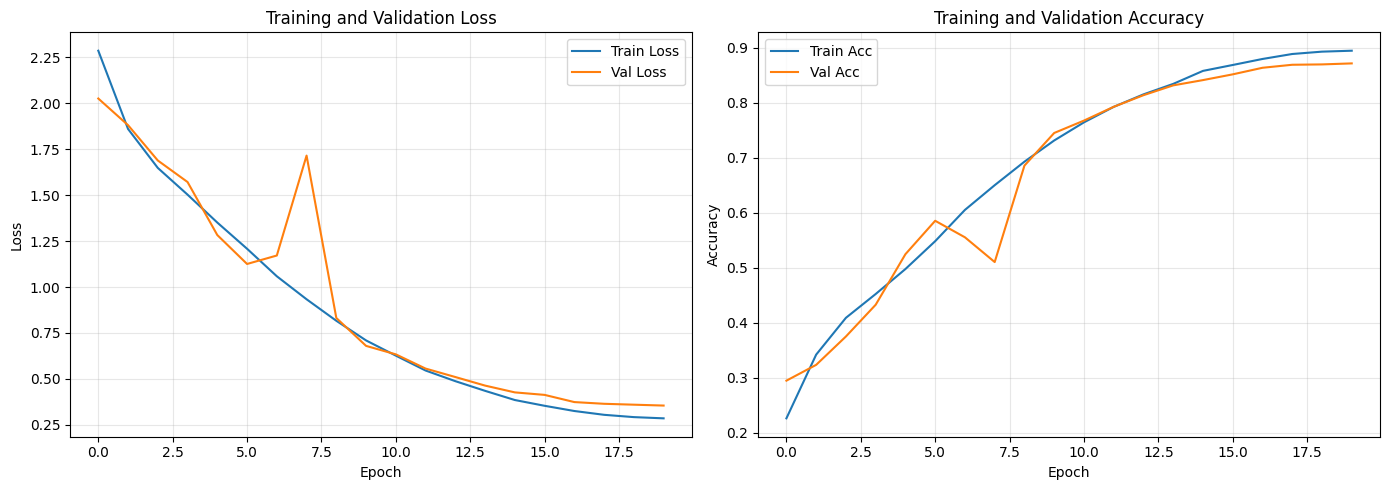


Best Validation Accuracy: 0.8713


In [10]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Acc')
axes[1].plot(val_accs, label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")

In [11]:
# Classification report
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)

# Create label names
label_names = [str(idx_to_anim[i]) for i in range(NUM_CLASSES)]

print(classification_report(best_labels, best_preds, target_names=label_names))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     2002000       0.96      0.98      0.97       600
     2003022       0.97      0.98      0.97       600
     2003017       0.96      0.94      0.95       600
     2003029       0.98      0.96      0.97       600
     2009000       0.78      0.80      0.79       600
     2003026       0.87      0.92      0.89       600
     2003021       0.96      0.93      0.94       600
     2003027       0.97      0.95      0.96       600
     2002003       0.98      0.97      0.97       600
     2002002       0.96      0.97      0.96       600
       41002       0.56      0.63      0.59       600
       41001       0.63      0.57      0.60       600
     2003025       0.91      0.90      0.90       558
       41000       0.71      0.66      0.68       493
     2003006       0.88      0.91      0.89       443
       other       0.85      0.84      0.85       600

    accuracy                           0.87      9294
   m

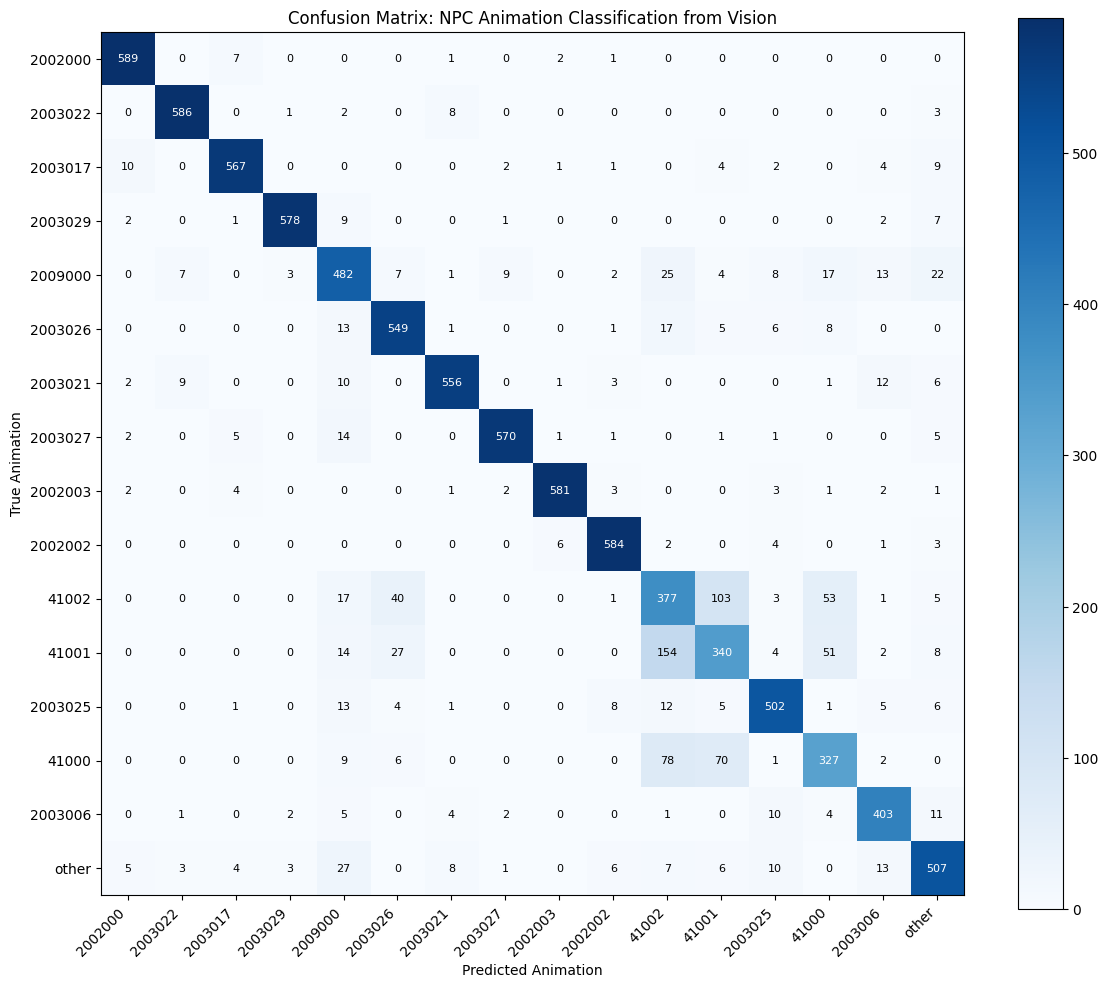

In [12]:
# Confusion matrix
cm = confusion_matrix(best_labels, best_preds)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix: NPC Animation Classification from Vision')
plt.colorbar()

tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, label_names, rotation=45, ha='right')
plt.yticks(tick_marks, label_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8)

plt.ylabel('True Animation')
plt.xlabel('Predicted Animation')
plt.tight_layout()
plt.show()

In [13]:
# Interpretation
print("="*60)
print("INTERPRETATION")
print("="*60)

if best_val_acc > 0.5:
    print(f"\n SUCCESS: CNN can recognize NPC animations from vision!")
    print(f"Accuracy: {best_val_acc:.1%}")
    print(f"\nImplications:")
    print(f"1. Visual features contain animation information")
    print(f"2. Can add animation prediction as auxiliary task")
    print(f"3. May improve dodge timing by forcing visual attack recognition")
elif best_val_acc > 0.3:
    print(f"\n PARTIAL: CNN has some ability to recognize animations")
    print(f"Accuracy: {best_val_acc:.1%}")
    print(f"\nMay need:")
    print(f"1. More frames (longer temporal context)")
    print(f"2. Higher resolution")
    print(f"3. Better architecture (3D conv, attention)")
else:
    print(f"\n FAILED: CNN cannot reliably recognize animations")
    print(f"Accuracy: {best_val_acc:.1%}")
    print(f"\nPossible reasons:")
    print(f"1. Resolution too low to see attack details")
    print(f"2. Animations visually similar at this scale")
    print(f"3. Need different approach (optical flow, attention)")

INTERPRETATION

 SUCCESS: CNN can recognize NPC animations from vision!
Accuracy: 87.1%

Implications:
1. Visual features contain animation information
2. Can add animation prediction as auxiliary task
3. May improve dodge timing by forcing visual attack recognition


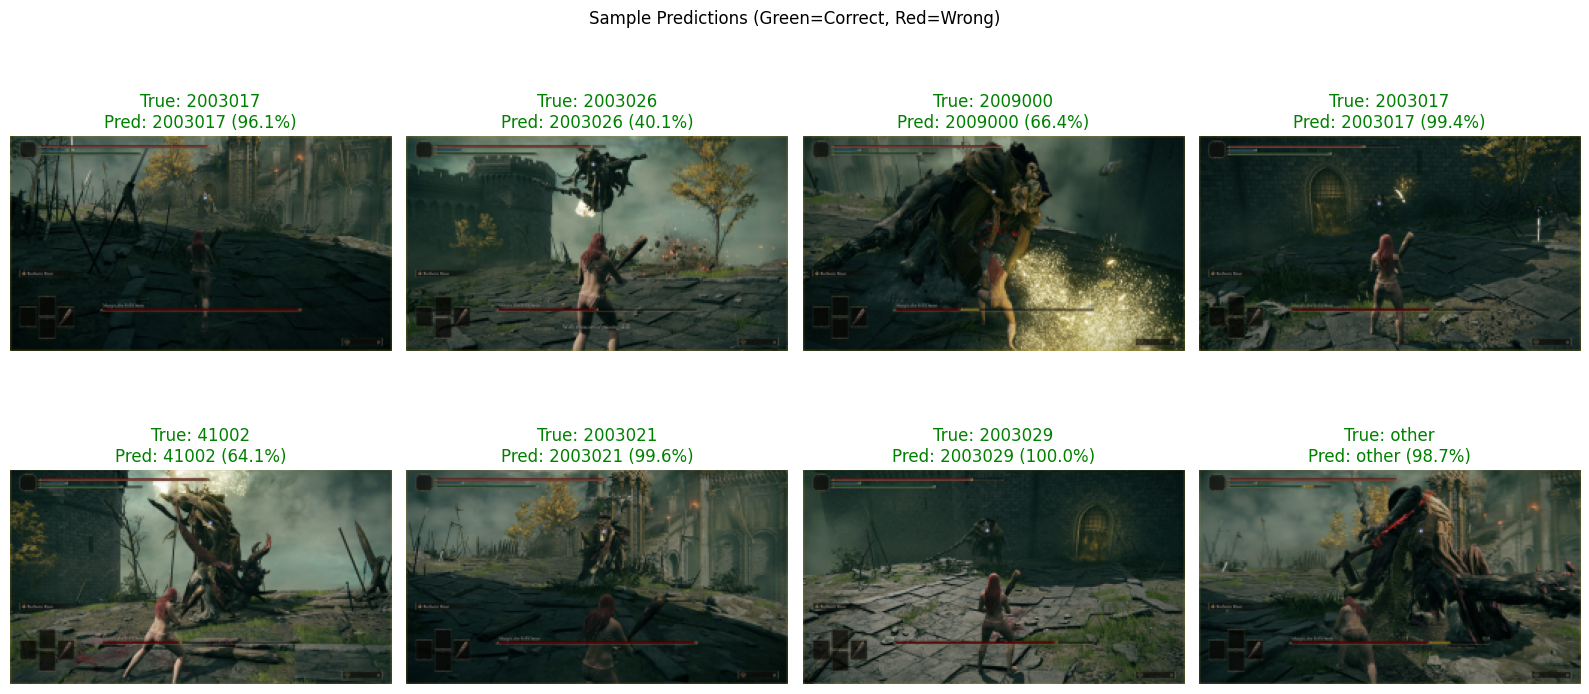

In [14]:
# Visualize some predictions
def visualize_predictions(model, dataset, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        frames, label = dataset[idx]
        
        # Get prediction
        with torch.no_grad():
            pred = model(frames.unsqueeze(0).to(DEVICE))
            pred_class = pred.argmax(1).item()
            confidence = F.softmax(pred, dim=1)[0, pred_class].item()
        
        # Show middle frame (current frame)
        mid_frame = frames[-3:].numpy()  # Last 3 channels = current frame
        mid_frame = np.transpose(mid_frame, (1, 2, 0))  # CHW -> HWC
        mid_frame = mid_frame[:, :, ::-1]  # BGR -> RGB
        
        axes[i].imshow(mid_frame)
        
        true_anim = idx_to_anim[label]
        pred_anim = idx_to_anim[pred_class]
        color = 'green' if label == pred_class else 'red'
        
        axes[i].set_title(f'True: {true_anim}\nPred: {pred_anim} ({confidence:.1%})', color=color)
        axes[i].axis('off')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset)